In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [2]:
# Load the data
df = pd.read_csv('node1_data.csv')

In [3]:
# For the purpose of this demonstration, we are randomly assigning some rows as charging points.
# In a real-world scenario, you would want a meaningful method to label these points.
df['charging_point'] = [1 if i % 10 == 0 else 0 for i in range(len(df))]

In [4]:
# Feature Selection
features = ['current_speed', 'charge', 'consumption', 'distance_covered', 'battery_capacity', 'battery_life', 'distance_to_charging_point']
X = df[features]
y = df['charging_point']

In [5]:
# Model training using cross-validation
clf = RandomForestClassifier(random_state=42)  # Setting a random state for reproducibility

In [6]:
# Create a copy of the DataFrame slice
X = X.copy()

# Display columns which contain 'inf' or '-inf' values
inf_columns = X.columns[X.isin([float('inf'), -float('inf')]).any()].tolist()
print(f"Columns with inf values: {inf_columns}")

# Replace 'inf' and '-inf' values in those columns with NaN
for col in inf_columns:
    X[col].replace([float('inf'), -float('inf')], float('nan'), inplace=True)

# Optionally, fill NaN values with a specified value or method
# Here, we're replacing NaN with the mean of the column
for col in inf_columns:
    X[col].fillna(X[col].mean(), inplace=True)

Columns with inf values: []


In [7]:
# Using 5-fold cross-validation
scores = cross_val_score(clf, X, y, cv=5)

In [8]:
# Display the scores for each fold
for i, score in enumerate(scores, 1):
    print(f"Fold-{i} Accuracy: {score:.4f}")

Fold-1 Accuracy: 0.8933
Fold-2 Accuracy: 0.8536
Fold-3 Accuracy: 0.8954
Fold-4 Accuracy: 0.8952
Fold-5 Accuracy: 0.8616


In [9]:
# Display the average accuracy across all folds
print(f"\nAverage Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")


Average Accuracy: 0.8798 ± 0.0183


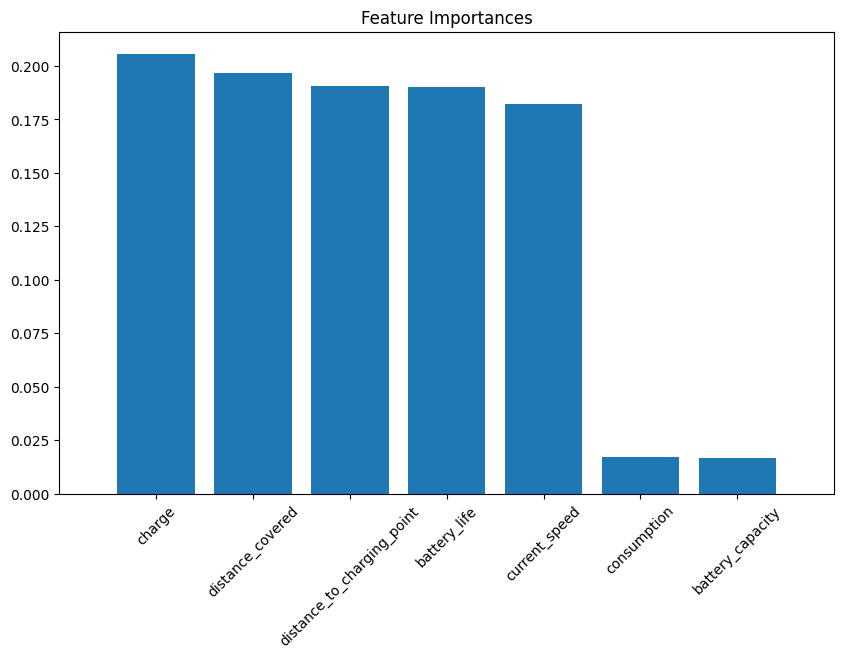

In [10]:
# Train the classifier on the entire dataset for this demonstration
clf.fit(X, y)
importances = clf.feature_importances_

# Visualizing feature importances
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
indices = np.argsort(importances)[::-1]
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(features)[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()


In [11]:
from sklearn.model_selection import GridSearchCV

# Parameters to tune
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X, y)

best_clf = grid_search.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END max_depth

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
import shap
from tqdm.notebook import tqdm

# Create a Tree explainer
explainer = shap.TreeExplainer(best_clf)
shap_values = explainer.shap_values(X_test)

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0])

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [14]:
from sklearn.metrics import accuracy_score

y_pred = best_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9142


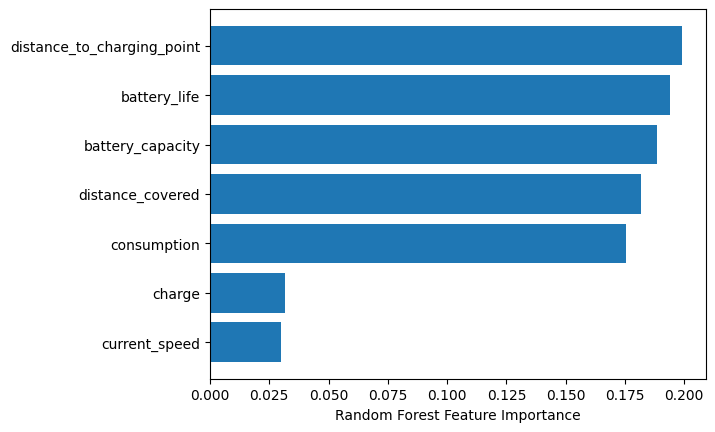

In [15]:
importances = best_clf.feature_importances_
sorted_idx = importances.argsort()

import matplotlib.pyplot as plt

plt.barh(features, importances[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.show()

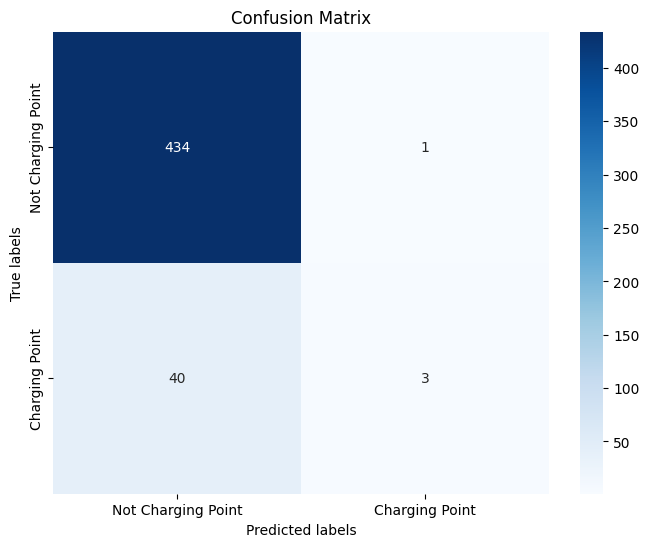

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = best_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Not Charging Point', 'Charging Point'], yticklabels=['Not Charging Point', 'Charging Point'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

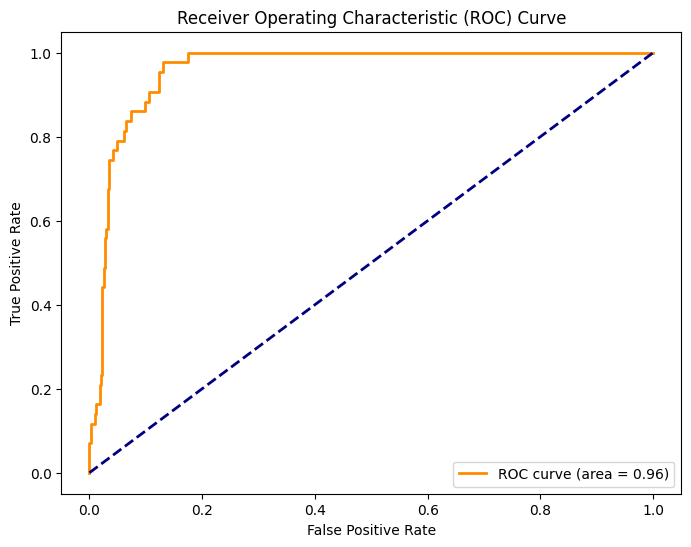

In [17]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, best_clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

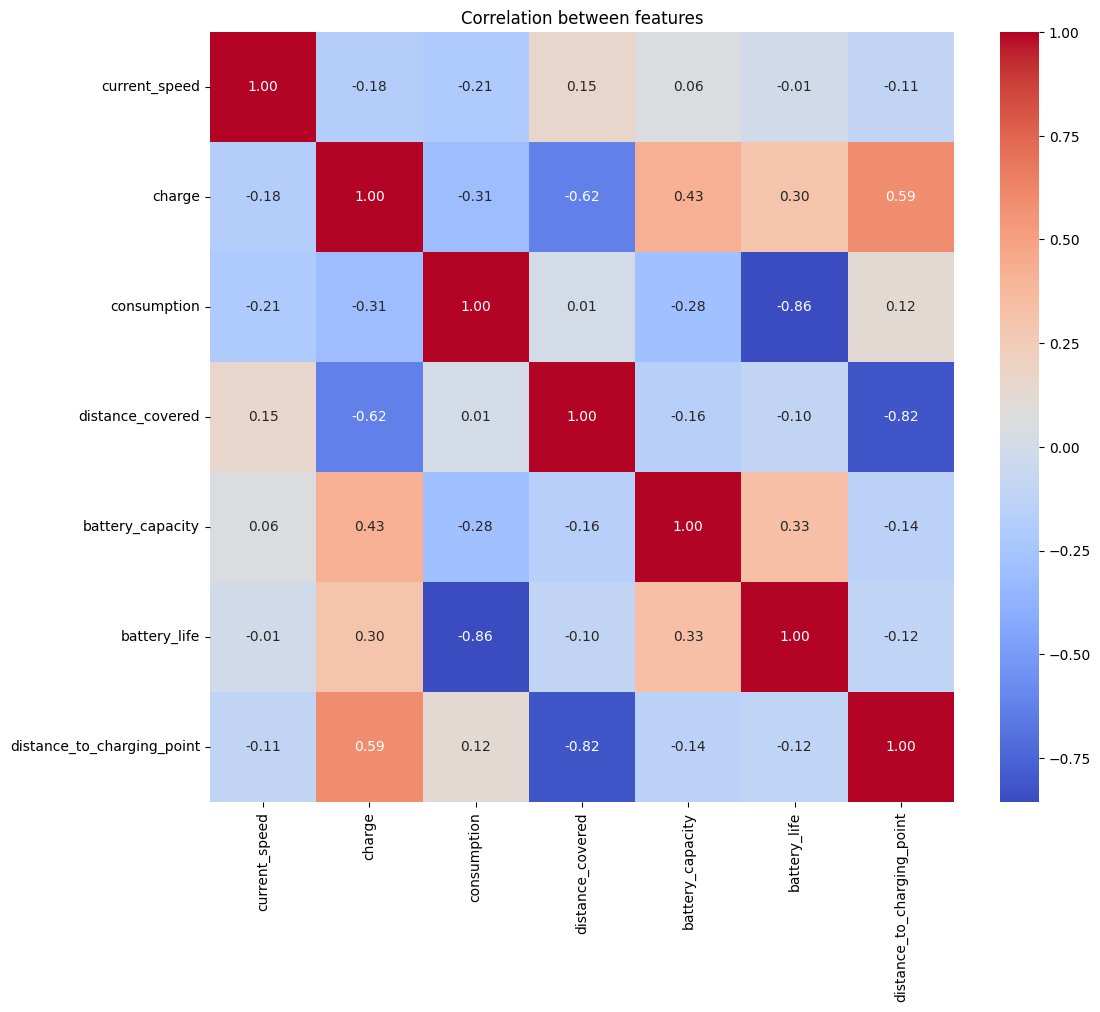

In [18]:
correlation = X.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation between features')
plt.show()

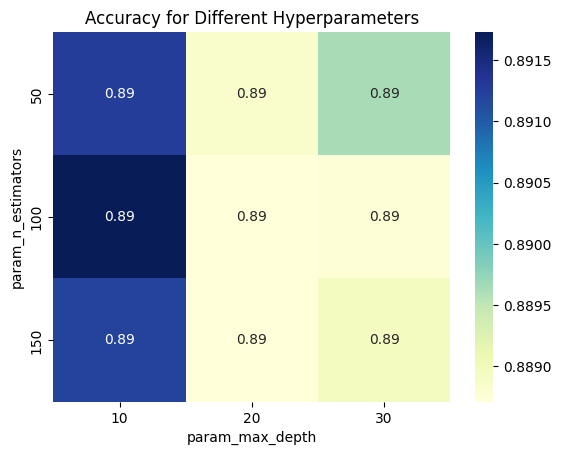

In [19]:
# Assuming grid_clf is your GridSearchCV object
results = pd.DataFrame(grid_search.cv_results_)
# Let's say you varied 'n_estimators' and 'max_depth' for visualization
pivoted = results.pivot_table(index='param_n_estimators', columns='param_max_depth', values='mean_test_score')
sns.heatmap(pivoted, annot=True, cmap='YlGnBu')
plt.title('Accuracy for Different Hyperparameters')
plt.show()

In [20]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=['Not Charging', 'Charging'])
print(report)

              precision    recall  f1-score   support

Not Charging       0.92      1.00      0.95       435
    Charging       0.75      0.07      0.13        43

    accuracy                           0.91       478
   macro avg       0.83      0.53      0.54       478
weighted avg       0.90      0.91      0.88       478



In [24]:
import joblib

model_filename = 'random_forest_model.pkl'
joblib.dump(best_clf, model_filename)

print(f"Model saved as {model_filename}")

Model saved as random_forest_model.pkl


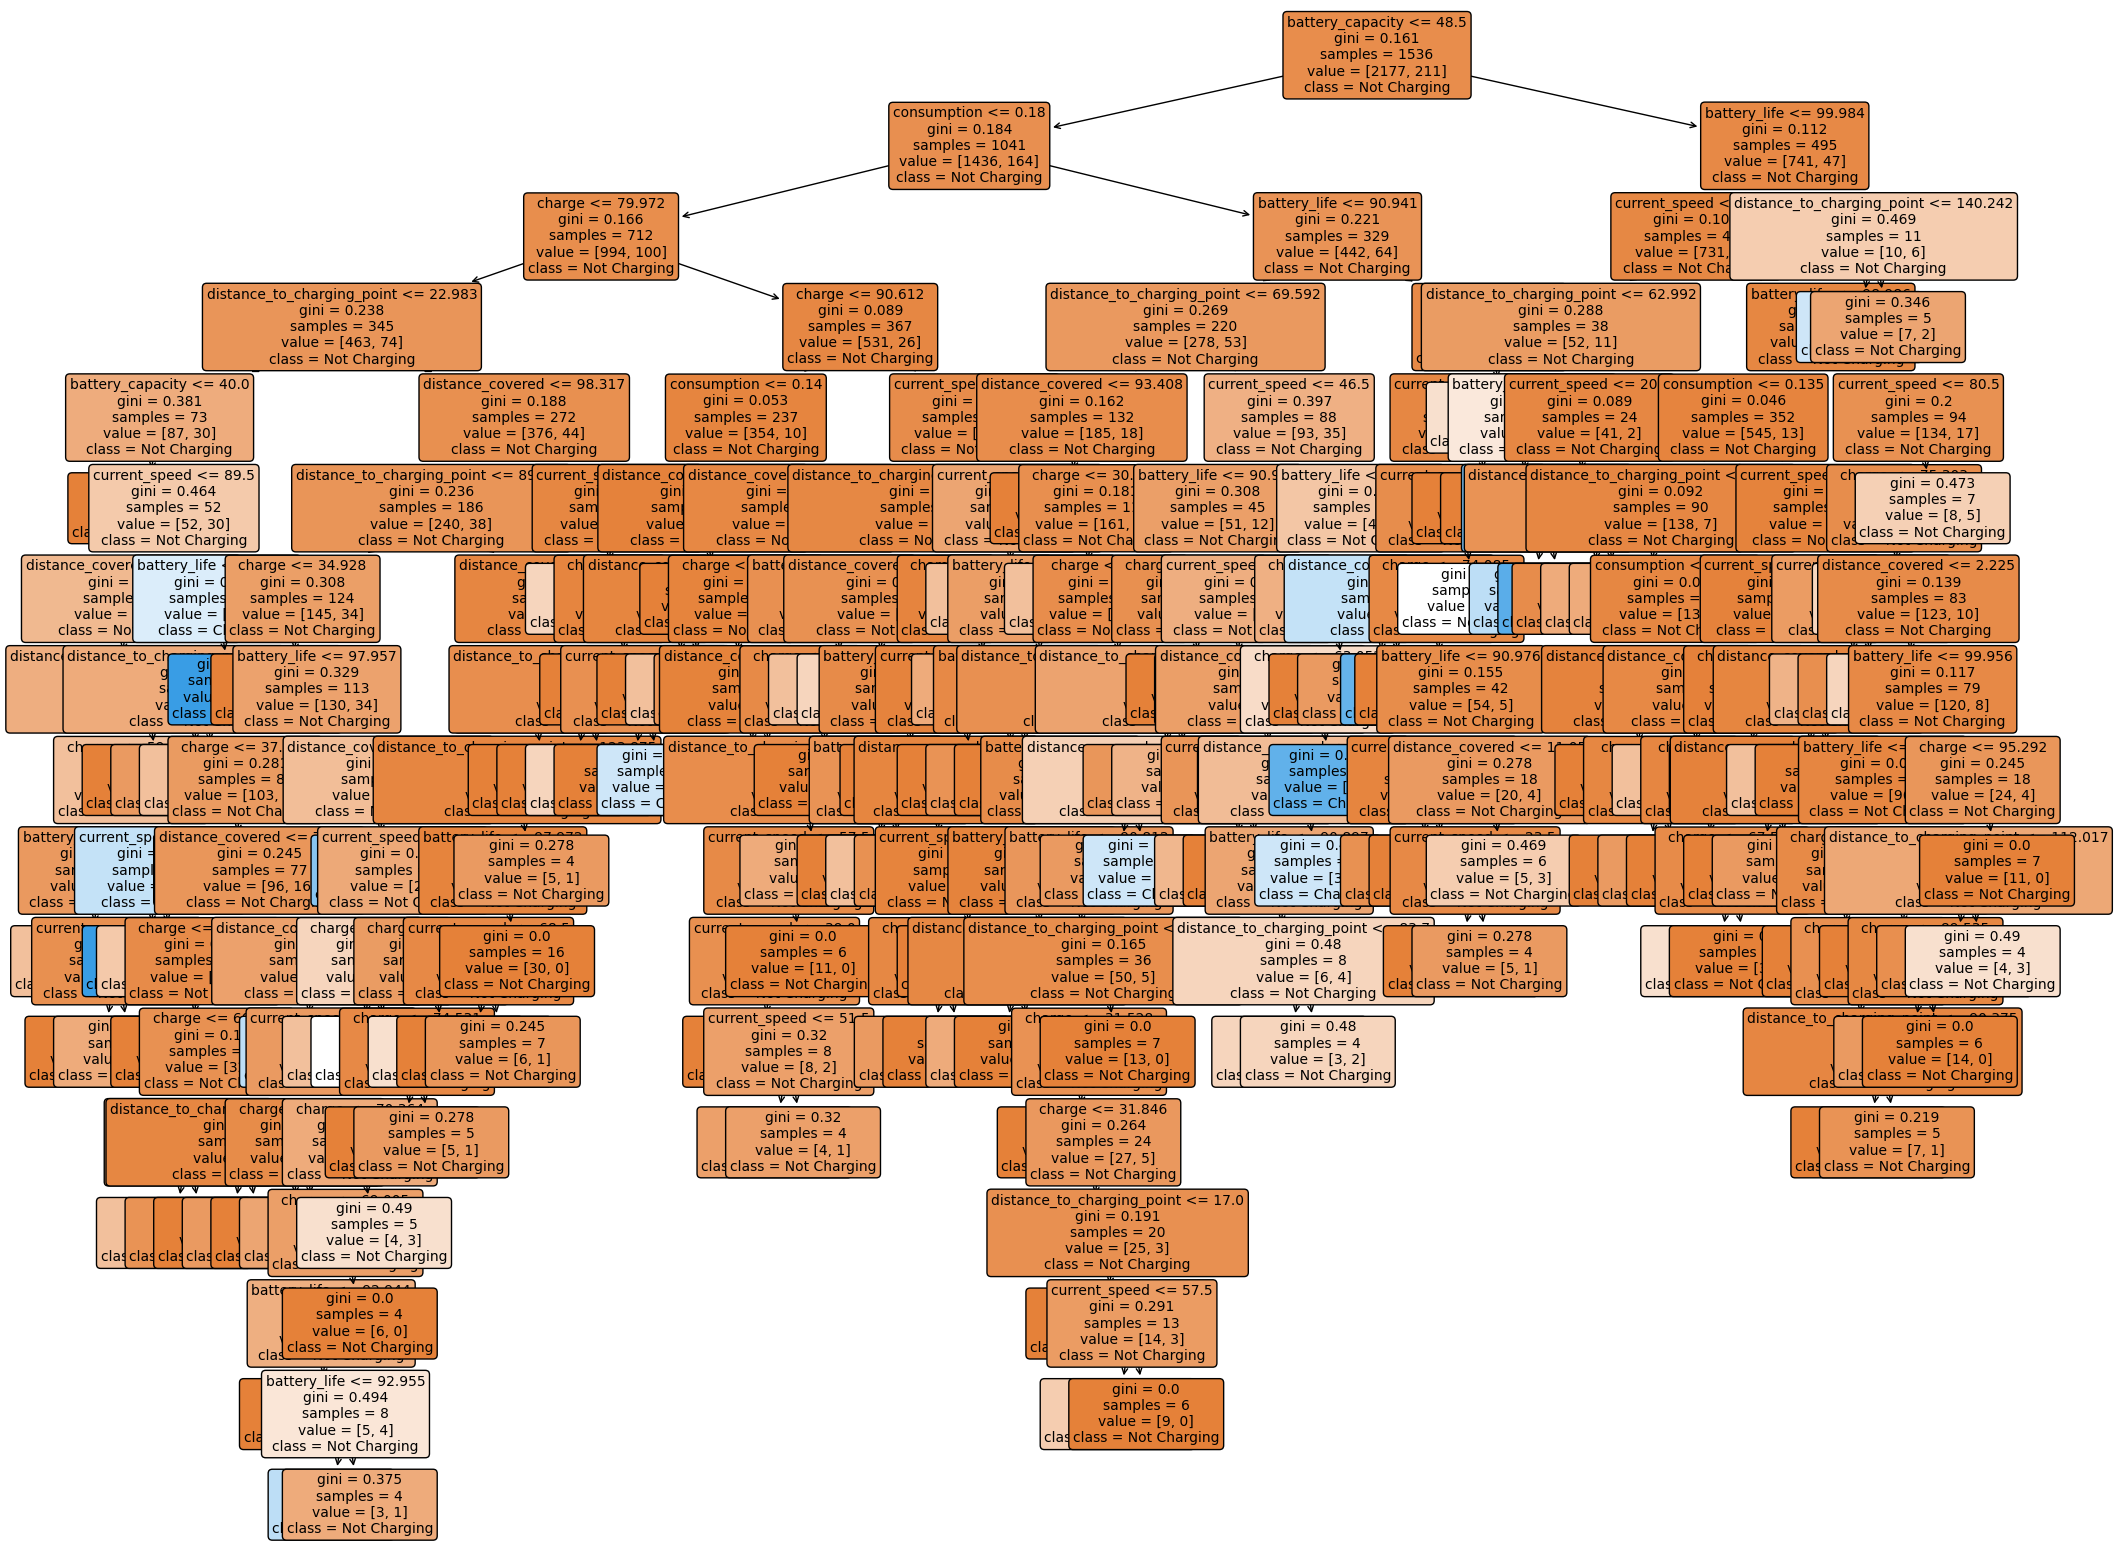

In [26]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Select one tree from the forest
tree = best_clf.estimators_[0]  # for instance, we choose the first tree

# Plot the tree
plt.figure(figsize=(25, 20))
plot_tree(tree, feature_names=features, class_names=["Not Charging", "Charging"], filled=True, rounded=True, fontsize=10)
plt.show()